## Задача 2. Анализ вакансий

Ежедневно работодатели публикуют тысячи вакансий в самых разных сферах деятельности. Тот факт, что зарплата часто не указывается в тексте вакансии, усложняет процесс размещения вакансий для самих же работодателей, т.к. им в итоге сложно оценить обстановку на рынке и предоставить соискателям интересное предложение. При этом, если заработная плата указана, работодателям проще и рекомендовать вакансию заинтересованным людям, и подбирать подходящих кандидатов. 

В рамках данной задачи вам предлагается построить модель, которая будет прогнозировать предлагаемую работодателем заработную плату на основе описания вакансии.

Для построения модели вам будут доступны данные о размещенных вакансиях, включая род деятельности компаний, требования к кандидатам и предлагаемые условия. Целевая переменная представляет собой среднюю заработную плату, указанную в вакансии.

Необходимо сделать прогнозы для всех объектов, которые находятся в файле с тестовыми данными. 

### Снова: загрузка и обработка :)

In [120]:
import pandas as pd

In [121]:
X = pd.read_csv('train.tsv.gz', sep = '\t')
X

,id,name,employer_name,experience_name,schedule_name,key_skills_name,accept_handicapped,accept_kids,unified_address_city,unified_address_state,...,raw_branded_description,lemmaized_wo_stopwords_raw_description,lemmaized_wo_stopwords_raw_branded_description,if_foreign_language,is_branded_description,name_clean,employment_name,employer_id,employer_industries,salary_mean_net
0,49242400,Инженер группы технической поддержки,DatsTeam,От 1 года до 3 лет,Сменный график,не указано,False,False,Москва,Москва,...,NaN,разрабатывать рекламный система оплата действи...,NaN,Не указано,заполнено,инженер группа технический поддержка,Полная занятость,4437201.0,не указано,80000.00
1,49496801,Специалист группы кадрового администрирования,Почта России,Нет опыта,Полный день,оформление трудовых книжек,False,False,Абакан,Республика Хакасия,...,АО «Почта России» входит в перечень системообр...,обязанность ведение кадровый делопроизводство ...,ао почта россия входить перечень системообразу...,Не указано,не заполнено,специалист группа кадровый администрирование,Полная занятость,4352.0,почтовая доставка,19989.12
2,44198403,Оператор 1С,Стройгарантсервис,От 1 года до 3 лет,Полный день,первичные документы,False,False,Москва,Москва,...,NaN,условие график работа 5/2 09.00 18.00;• оформл...,NaN,Не указано,заполнено,оператор 1с,Полная занятость,1794943.0,лифты,45000.00
3,47707600,Инженер ПТО,Коммунальник,От 3 до 6 лет,Полный день,autocad,False,False,NaN,Краснодарский край,...,NaN,строительный инженерный компания коммунальник ...,NaN,Не указано,заполнено,инженер пто,Полная занятость,1881241.0,не указано,40000.00
4,44610002,Водитель в войсковую часть (пункт отбора на во...,Пункт отбора на военную службу по контракту по...,Нет опыта,Полный день,водительское удостоверение категории bc,False,False,NaN,Калужская область,...,NaN,обязанность знать устройство правило эксплуата...,NaN,Не указано,заполнено,водитель войсковой часть пункт отбор военный с...,Полная занятость,1586217.0,не указано,37500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61309,49132201,Инженер ОТК,РГМ-Нефть-Газ-Сервис,От 1 года до 3 лет,Полный день,не указано,False,False,Воронеж,Воронежская область,...,NaN,обязанность контроль сварка вика контроль дета...,NaN,Не указано,заполнено,инженер отк,Полная занятость,1089764.0,не указано,30450.00
61310,41386400,Врач-эндокринолог (г. Геленджик),ГКУ КК ЦЗН города Геленджик,Нет опыта,Полный день,не указано,False,False,NaN,Калининградская область,...,NaN,обязанность выполнять перечень работа услуга д...,NaN,Не указано,заполнено,врач эндокринолог г. геленджик,Полная занятость,4481442.0,не указано,30450.00
61311,43351202,Швея-портной,Дом Быта,От 3 до 6 лет,Полный день,работа с клиентами,False,False,Москва,Москва,...,NaN,обязанность ремонт реставрация одежда перекрой...,NaN,Не указано,заполнено,швея портной,Полная занятость,4159812.0,не указано,60000.00
61312,44745603,Специалист помощи пользователям Яндекс.Учебника,Яндекс Крауд,Нет опыта,Удаленная работа,не указано,True,False,Пушкино,Московская область,...,NaN,день сервис яндекс пользоваться миллион челове...,NaN,Не указано,заполнено,специалист помощь пользователь яндекс учебник,Частичная занятость,9498112.0,не указано,13000.00


In [122]:
X.dtypes

id                                                  int64
name                                               object
employer_name                                      object
experience_name                                    object
schedule_name                                      object
key_skills_name                                    object
accept_handicapped                                   bool
accept_kids                                          bool
unified_address_city                               object
unified_address_state                              object
unified_address_region                             object
unified_address_country                            object
specializations_profarea_name                      object
professional_roles_name                            object
languages_name                                     object
raw_description                                    object
raw_branded_description                            object
lemmaized_wo_s

#### Пропуски

In [16]:
X.isnull().sum()[X.isnull().sum()>0]

unified_address_city                              14333
unified_address_region                                7
raw_branded_description                           56343
lemmaized_wo_stopwords_raw_branded_description    56343
employer_id                                          54
dtype: int64

In [123]:
# Описания заполняем пустыми строками
X['raw_branded_description'] = X['raw_branded_description'].fillna("")
X['lemmaized_wo_stopwords_raw_branded_description'] = X['lemmaized_wo_stopwords_raw_branded_description'].fillna("")

# Айдишник и регион - выделяем в отдельную категорию
X['employer_id'] = X['employer_id'].fillna(-1)

X['unified_address_region'] = X['unified_address_region'].fillna('Undefined')
X['unified_address_city'] = X['unified_address_city'].fillna('Undefined')

# from flashgeotext.geotext import GeoText

#### Типы

In [124]:
X['accept_handicapped'] = X['accept_handicapped'].astype(int)
X['accept_kids'] = X['accept_kids'].astype(int)

X['employer_id'] = X['employer_id'].astype(int)

In [125]:
X[X['lemmaized_wo_stopwords_raw_branded_description'].apply(lambda x: len(x)) != 0].shape

X['is_branded_description'] = X['is_branded_description'].apply(lambda x: 0 if x == 'заполнено' else 1)

In [126]:
X['if_foreign_language'] = X['if_foreign_language'].apply(lambda x: 1 if x == 'Указано' else 0)

In [127]:
X['key_skills_name'] = X['key_skills_name'].apply(lambda x: x if x != 'не указано' else '')

#### Удаляем ненужное

In [128]:
# Все вакансии из России
to_drop = ['unified_address_country', 'unified_address_state']

to_drop += ['raw_description', 'raw_branded_description', 'name']

X = X.drop(columns = to_drop)

#### Кодирование категориальных признаков

In [131]:
label_enc_features = ['experience_name', 
                      'unified_address_city',
                      'schedule_name', 
                      'unified_address_region', 
                      'specializations_profarea_name', 
                      'employment_name', 
                      'employer_industries']

In [132]:
from sklearn.preprocessing import LabelEncoder

for f in label_enc_features:
    lab_enc = LabelEncoder()
    X[f] = lab_enc.fit_transform(X[f])

In [133]:
X

,id,employer_name,experience_name,schedule_name,key_skills_name,accept_handicapped,accept_kids,unified_address_city,unified_address_region,specializations_profarea_name,...,languages_name,lemmaized_wo_stopwords_raw_description,lemmaized_wo_stopwords_raw_branded_description,if_foreign_language,is_branded_description,name_clean,employment_name,employer_id,employer_industries,salary_mean_net
0,49242400,DatsTeam,2,3,,0,0,83,7,11,...,[],разрабатывать рекламный система оплата действи...,,0,0,инженер группа технический поддержка,1,4437201,110,80000.00
1,49496801,Почта России,1,2,оформление трудовых книжек,0,0,1,5,18,...,[],обязанность ведение кадровый делопроизводство ...,ао почта россия входить перечень системообразу...,0,1,специалист группа кадровый администрирование,1,4352,147,19989.12
2,44198403,Стройгарантсервис,2,2,первичные документы,0,0,83,7,18,...,[],условие график работа 5/2 09.00 18.00;• оформл...,,0,0,оператор 1с,1,1794943,94,45000.00
3,47707600,Коммунальник,3,2,autocad,0,0,0,8,24,...,[],строительный инженерный компания коммунальник ...,,0,0,инженер пто,1,1881241,110,40000.00
4,44610002,Пункт отбора на военную службу по контракту по...,1,2,водительское удостоверение категории bc,0,0,0,7,18,...,[],обязанность знать устройство правило эксплуата...,,0,0,водитель войсковой часть пункт отбор военный с...,1,1586217,110,37500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61309,49132201,РГМ-Нефть-Газ-Сервис,2,2,,0,0,33,7,18,...,[],обязанность контроль сварка вика контроль дета...,,0,0,инженер отк,1,1089764,110,30450.00
61310,41386400,ГКУ КК ЦЗН города Геленджик,1,2,,0,0,0,3,15,...,[],обязанность выполнять перечень работа услуга д...,,0,0,врач эндокринолог г. геленджик,1,4481442,110,30450.00
61311,43351202,Дом Быта,3,2,работа с клиентами,0,0,83,7,18,...,[],обязанность ремонт реставрация одежда перекрой...,,0,0,швея портной,1,4159812,110,60000.00
61312,44745603,Яндекс Крауд,1,4,,1,0,128,7,18,...,[],день сервис яндекс пользоваться миллион челове...,,0,0,специалист помощь пользователь яндекс учебник,4,9498112,110,13000.00


### Строим модели

#### 1. Базовое интуитивное решение

In [134]:
X[['professional_roles_name', 'specializations_profarea_name']].head(5)

,professional_roles_name,specializations_profarea_name
0,специалист технической поддержки,11
1,специалист по кадрам,18
2,оператор базы данных,18
3,инженер-проектировщик,24
4,водитель,18


In [135]:
from tqdm import tqdm


def fit(X):
    value_matrix = {}
    tuple_values = []
    values = X[['professional_roles_name', 'specializations_profarea_name']].values
    
    for el in values:
        tuple_values.append(tuple(el))
        
    for el in tqdm(tuple_values):
        value_matrix[el] = X.loc[(X['professional_roles_name'] == el[0]) & 
                   (X['specializations_profarea_name'] == el[1])].salary_mean_net.mean()
    return value_matrix, X.salary_mean_net.mean()



def transform(X, value_matrix, mean_val):
    results = []
    ooo = 0
    for el in tqdm(X[['professional_roles_name', 'specializations_profarea_name']].values):
        if tuple(el) in value_matrix:
            results.append(value_matrix[tuple(el)])
        else:
            results.append(mean_val)
            ooo += 1
    print("ooo elements: ", ooo)
    return results

In [136]:
value_matrix, mean_val = fit(X)

100%|██████████| 61314/61314 [04:08<00:00, 246.47it/s]


In [137]:
value_matrix

{('специалист технической поддержки', 11): 42790.18987341772,
 ('специалист по кадрам', 18): 43147.93269607843,
 ('оператор базы данных', 18): 33474.9944076655,
 ('инженер-проектировщик', 24): 68594.85258964144,
 ('водитель', 18): 63892.941146687,
 ('продюсер', 18): 66571.36428571428,
 ('бизнес-тренер', 18): 59440.49267605635,
 ('другое', 18): 46911.31379253901,
 ('менеджер по закупкам', 18): 52522.40570544555,
 ('менеджер по продажам', 17): 55046.44736842105,
 ('продавец-консультант', 19): 33595.09874529737,
 ('секретарь', 1): 41500.35075342466,
 ('продавец-консультант', 18): 33608.44993814344,
 ('администратор', 18): 34855.93819742489,
 ('грузчик', 18): 36178.24587719298,
 ('специалист по подбору персонала', 18): 45210.54219455423,
 ('юрисконсульт', 28): 52562.056804123706,
 ('автомеханик', 7): 78000.0,
 ('руководитель проектов', 18): 74311.29164402492,
 ('координатор отдела продаж', 18): 44577.02707107844,
 ('инженер-механик', 18): 56832.86478559177,
 ('врач', 18): 41529.82092698086

In [119]:
mean_val

51087.411418537544

In [85]:
predict = transform(X, value_matrix, mean_val)

100%|██████████| 61314/61314 [00:00<00:00, 438754.07it/s]

ooo elements:  0


In [ ]:
def MAPE(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))

In [87]:
print('MAPE train = 0.43246923476818905')
print('MAPE test = 0.4416622720433997')

MAPE train = 0.43246923476818905
MAPE test = 0.4416622720433997


#### 2. Решение без текста

In [93]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

params = {'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 50,
 'n_estimators': 400}


regr_gscv = RandomForestRegressor(**params, random_state=42)

regr_gscv.fit(X.drop(columns = ['salary_mean_net']).select_dtypes(include='number'), np.log(X['salary_mean_net']))
# логарифм!

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [97]:
y_pred_log = regr_gscv.predict(X.drop(columns = ['salary_mean_net']).select_dtypes(include='number'))

In [100]:
MAPE(X['salary_mean_net'], np.exp(y_pred_log))

0.28474790461772154

Составление признаков

- длина - у хороших вакансий описание более длинное, у плохих - вообще нет
- посчитать количество восклицательных и вопросительных знаков 
- посчитать необычные символы, например, смайлики :), :(
    
- составить словарь слов (интуитивно): (программист, менеджер \ грузчик, водитель)
Составление словаря в ручную - долгое занятие и не гарантирует хорошего результата.

#### 3. Мешок слов (bag of words, BoW)

Выбрать отдельные слова и сделать признаком их количество в тексте

In [69]:
example = pd.DataFrame()
example[''] = ['Вакансия_1', 'Вакансия_2', 'Вакансия_3']
example['тортик'] = [0, 1, 0]
example['котики'] = [2, 5, 1]
example['чай'] = [0, 0, 2]
example

,,тортик,котики,чай
0,Вакансия_1,0,2,0
1,Вакансия_2,1,5,0
2,Вакансия_3,0,1,2


#### Нормализация слов

In [140]:
to_token = ['employer_name', 'key_skills_name', 'professional_roles_name', 'languages_name']
ready = ['lemmaized_wo_stopwords_raw_description', 'lemmaized_wo_stopwords_raw_branded_description', 'name_clean']

Обработка текста

- Выделить слова, убрать другие символы (токенизация) - можно вручную через split, через регулярные выражения, с библиотекой nltk
- Выравнивание по регистру - .lower() с осторожностью, тк потеряем имена собственные
- Убрать стоп-слова (nltk)
- Нормализация слова - стемминг (выделение основы) или лемматизация (приведение к словарной форме), обычно второе (pymorphy2)

In [110]:
from nltk.tokenize import word_tokenize

text = "Это пример русского предложения. Оно содержит несколько слов"
tokens = word_tokenize(text, language='russian')

# [‘Это’, ‘пример’, ‘русского’, ‘предложения’, ‘.’, ‘Оно’, ‘содержит’, ‘несколько’, ‘слов’, ‘!’]

In [111]:
from pymystem3 import Mystem

m = Mystem()
lemmatized = m.lemmatize("Это пример русского предложения. Оно содержит несколько слов")

# ['Это', "пример", "русский", "предложение", "оно", "содержать", "несколько", "слово"]

In [145]:
X = X.drop(columns = to_token)

#### 4. Предобработка текста - TF-IDF

В каком из двух текстов слово “собака” встретится чаще?
1. записка ветеринару
2. Война и Мир

В каком из этих текстов это слово важнее?

По этой причине счетчики слов нормируют на количество слов в документе
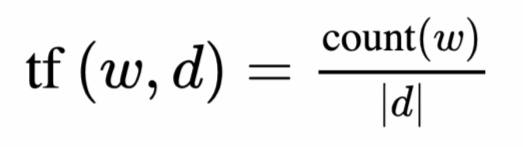

Скорее всего, часто будут встречаться самые распространённые слова

Это учитывают - отдельно считают частоту появления слова во всех текстах
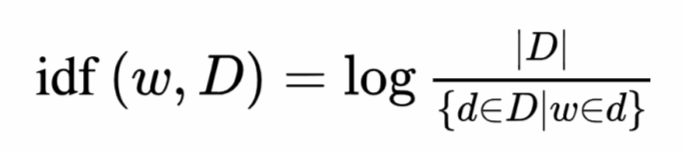

Объединённая формула:
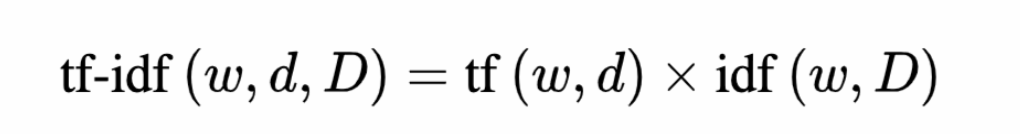

.

#### Случайный лес ТОЛЬКО на описании вакансии

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pipe = Pipeline(steps=[("tfidf", TfidfVectorizer(max_features=10)), 
                       ("regressor", RandomForestRegressor(max_depth=100,
                                                           min_samples_split=5,
                                                           n_estimators=300)
                       )], verbose=True)

pipe.fit(X['lemmaized_wo_stopwords_raw_description'], np.log(X['salary_mean_net']))

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   5.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 9.0min


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?...
                                 vocabulary=None)),
                ('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=100, max_features='auto',
                                       max_leaf_nodes=None,
             

In [149]:
y_pred_log = pipe.predict(X['lemmaized_wo_stopwords_raw_description'])

In [150]:
MAPE(X['salary_mean_net'], np.exp(y_pred_log))

0.2993151548779842

### 5. Все признаки

In [154]:
from sklearn.feature_extraction.text import CountVectorizer

freq_vector = CountVectorizer(max_features = 100)
word_matrix = freq_vector.fit_transform(X['lemmaized_wo_stopwords_raw_description'].values)

word_matrix

<61314x100 sparse matrix of type '<class 'numpy.int64'>'
	with 1431797 stored elements in Compressed Sparse Row format>

In [155]:
raw_dt = pd.DataFrame(word_matrix.toarray(), columns = ["t_raw_" + str(num) for num in range(100)])
X = pd.concat([X, raw_dt], axis=1)

X = X.drop(columns = 'lemmaized_wo_stopwords_raw_description')
X.head(2)

,id,experience_name,schedule_name,accept_handicapped,accept_kids,unified_address_city,unified_address_region,specializations_profarea_name,lemmaized_wo_stopwords_raw_branded_description,if_foreign_language,...,t_raw_90,t_raw_91,t_raw_92,t_raw_93,t_raw_94,t_raw_95,t_raw_96,t_raw_97,t_raw_98,t_raw_99
0,49242400,2,3,0,0,83,7,11,,0,...,1,0,0,0,0,0,0,0,0,0
1,49496801,1,2,0,0,1,5,18,ао почта россия входить перечень системообразу...,0,...,1,0,0,0,1,0,0,0,0,0


In [168]:
freq_vector = CountVectorizer(max_features = 100)
word_matrix = freq_vector.fit_transform(X['lemmaized_wo_stopwords_raw_branded_description'].values)

raw_dt = pd.DataFrame(word_matrix.toarray(), columns = ["t_brand_" + str(num) for num in range(100)])
X = pd.concat([X, raw_dt], axis=1)

X = X.drop(columns = 'lemmaized_wo_stopwords_raw_branded_description')
X.head(2)

In [162]:
freq_vector = CountVectorizer(max_features = 100)
word_matrix = freq_vector.fit_transform(X['name_clean'].values)

raw_dt = pd.DataFrame(word_matrix.toarray(), columns = ["name_" + str(num) for num in range(100)])
X = pd.concat([X, raw_dt], axis=1)

X = X.drop(columns = 'name_clean')
X.head(2)

,id,experience_name,schedule_name,accept_handicapped,accept_kids,unified_address_city,unified_address_region,specializations_profarea_name,if_foreign_language,is_branded_description,...,t_brand_90,t_brand_91,t_brand_92,t_brand_93,t_brand_94,t_brand_95,t_brand_96,t_brand_97,t_brand_98,t_brand_99
0,49242400,2,3,0,0,83,7,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,49496801,1,2,0,0,1,5,18,0,1,...,0,0,0,0,0,0,0,0,0,0


In [163]:
params = {'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 50,
 'n_estimators': 400}


regr_gscv = RandomForestRegressor(**params, random_state=42)

regr_gscv.fit(X.drop(columns = ['salary_mean_net']).select_dtypes(include='number'), np.log(X['salary_mean_net']))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [164]:
y_pred_log = regr_gscv.predict(X.drop(columns = ['salary_mean_net']).select_dtypes(include='number'))

In [165]:
MAPE(X['salary_mean_net'], np.exp(y_pred_log))

0.25140666178485616

.

## Что еще можно:

* Добавить оставшиеся признаки


* Кодирование категориальных признаков при помощи:
  * OneHotEncoding
  * MeanTargetEncoding


* Заполнение пропусков не средним, а медианой, уникальным значением или прогнозом вспомогательной модели


* Подбор гиперпараметров модели:
  * GridSearchCV - подбор по сетке
  * Optuna - байесовский алгоритм быстрого подбора гиперпараметров


* Конструирование новых признаков:
  * PolynomialFeatures
  * Придумывать признаки, исходя из смысла


* Снижение размерности:
  * Отбор признаков (SelectKBest, RFE, SelectFromModel)
  * Снижение размерности (PCA, KernelPCA)


* Использование нескольких моделей (возможно, взвешенное среднее или стекинг как результат):
  * KNN
  * LinearRegression, Ridge, Lasso, ElasticNet
  * SVR
  * DecisionTree, RandomForest, GradientBoosting
  * CatBoost, XGBoost, LightGBM
  * DeepLearning-модели

### Гугл-диск с примерами:

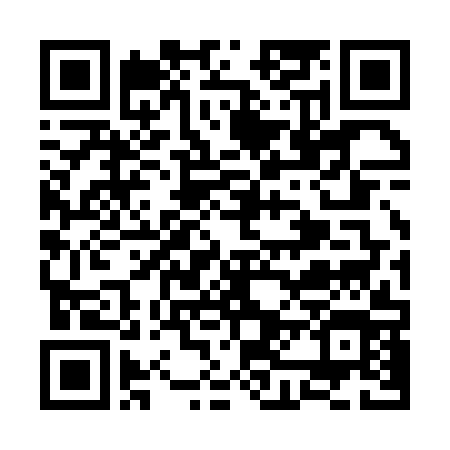